In [31]:
!pip install contextily geopandas shapely matplotlib pyproj


In [32]:
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import box
import geopandas as gpd
from pyproj import Transformer

def meters_to_latlon(center_lat, center_lon, width_m, height_m):
    proj_wgs84 = 'EPSG:4326'
    proj_mercator = 'EPSG:3857'
    transformer_to_merc = Transformer.from_crs(proj_wgs84, proj_mercator, always_xy=True)
    transformer_to_latlon = Transformer.from_crs(proj_mercator, proj_wgs84, always_xy=True)

    center_x, center_y = transformer_to_merc.transform(center_lon, center_lat)
    half_width = width_m / 2
    half_height = height_m / 2

    left = center_x - half_width
    right = center_x + half_width
    bottom = center_y - half_height
    top = center_y + half_height

    min_lon, min_lat = transformer_to_latlon.transform(left, bottom)
    max_lon, max_lat = transformer_to_latlon.transform(right, top)

    return min_lon, min_lat, max_lon, max_lat

def download_map(center_lat, center_lon, width_m, height_m, output_filename='downloaded_map.png'):
    left, bottom, right, top = meters_to_latlon(center_lat, center_lon, width_m, height_m)
    bbox = box(left, bottom, right, top)
    gdf = gpd.GeoDataFrame({'geometry': [bbox]}, crs='EPSG:4326')
    gdf = gdf.to_crs(epsg=3857)
    bounds = gdf.total_bounds  # xmin, ymin, xmax, ymax

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])

    ctx.add_basemap(ax, zoom=18, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.axis('off')
    plt.savefig(output_filename, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()
    print(f"Map saved as '{output_filename}'")




In [33]:
# # Example: Replace these with your actual area center coordinates
# center_lat = (51.100935+51.095632)/2  # your center latitude
# center_lon = (71.420360+71.429589)/2  # your center longitude
# width_m = 835         # width in meters
# height_m = 913        # height in meters
#
# # Call the function to download the map
# download_map(center_lat, center_lon, width_m, height_m)

In [34]:
# config.py
DB_PARAMS = {
    'dbname': 'webots_drone_async',
    'user': 'postgres',
    'password': '1',
    'host': 'localhost'
}


In [35]:
import psycopg2
# from config import DB_PARAMS

def get_positions(episode_id):
    conn = psycopg2.connect(**DB_PARAMS)
    cur = conn.cursor()

    query = """
        SELECT position_x, position_y
        FROM position_logs
        WHERE episode_id = %s
        AND timestep = (
            SELECT MIN(timestep)
            FROM position_logs
            WHERE episode_id = %s
        );
    """
    cur.execute(query, (episode_id, episode_id))
    positions = cur.fetchall()

    cur.close()
    conn.close()
    return positions



In [36]:
episode_id = 34  # Replace with your episode_id
positions = get_positions(episode_id)
print(positions)

[(2.219832658767719, 3.052474986988238e-16), (1.3840430245746187, 1.7355350584353015), (-0.49395923645572254, 2.164176819405425), (-2.0000001175027364, 0.9631492942014328), (-2.0000001175027284, -0.9631492942014473), (-0.49395923645572604, -2.1641768194054394), (1.38404302457461, -1.7355350584352929)]


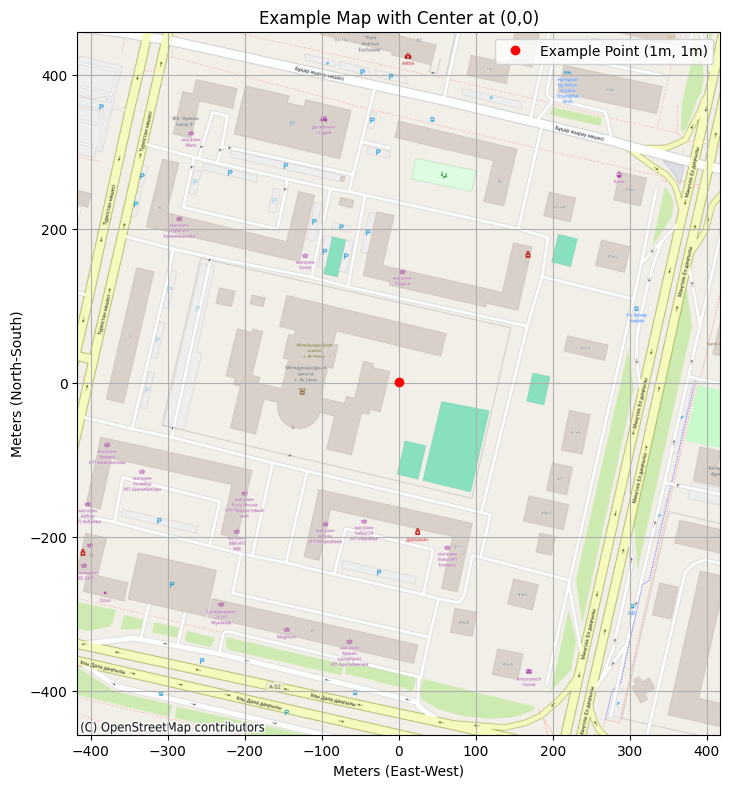

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def set_map_background(ax, image_path, map_width_m, map_height_m):
    """
    Set the given ax background as a map image centered at (0,0),
    with 1 unit = 1 meter.

    Parameters:
    - ax: matplotlib Axes object
    - image_path: str, path to the map image file (PNG, JPG, etc.)
    - map_width_m: float, real-world width of the map in meters
    - map_height_m: float, real-world height of the map in meters
    """
    map_image = mpimg.imread(image_path)
    extent = [-map_width_m / 2, map_width_m / 2, -map_height_m / 2, map_height_m / 2]
    ax.imshow(map_image, extent=extent, origin='upper')
    ax.set_xlabel('Meters (East-West)')
    ax.set_ylabel('Meters (North-South)')
    ax.grid(True)

# ============================
# 📌 Example usage:

fig, ax = plt.subplots(figsize=(8.35, 9.13))

# Example: Setting background using the function
set_map_background(ax, 'downloaded_map.png', map_width_m=835, map_height_m=913)

# Example: Plot a point at 1m right, 1m up from the center
ax.plot(1, 1, 'ro', label='Example Point (1m, 1m)')
ax.legend()
plt.title('Example Map with Center at (0,0)')
plt.show()


In [38]:
import matplotlib.pyplot as plt
import numpy as np

def plot_drone_positions(positions, ax=None, color='blue', marker='o', size=50, label='Drone positions'):
    """
    Plot initial positions of drones as scatter points.

    Parameters:
    - positions: list of tuples (x, y), each tuple is one drone's position
    - ax: matplotlib Axes object (optional), if None creates a new plot
    - color: color of the points
    - marker: marker style for the points
    - size: size of the points
    - label: label for the scatter plot
    """
    positions = np.array(positions)

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    ax.scatter(positions[:, 0], positions[:, 1], c=color, s=size, marker=marker, label=label)
    ax.set_xlabel('Meters (East-West)')
    ax.set_ylabel('Meters (North-South)')
    ax.set_title('Initial Positions of Drones')
    ax.legend()
    ax.grid(True)

    return ax

# ==========================
# 📌 Example usage:
# positions = [(1.0, 2.0), (-3.0, 4.0), (2.5, -1.5), ...]  # Your positions list from DB
# ax = set_map_background(...)  # If using background function
# plot_drone_positions(positions, ax=ax)
# plt.show()


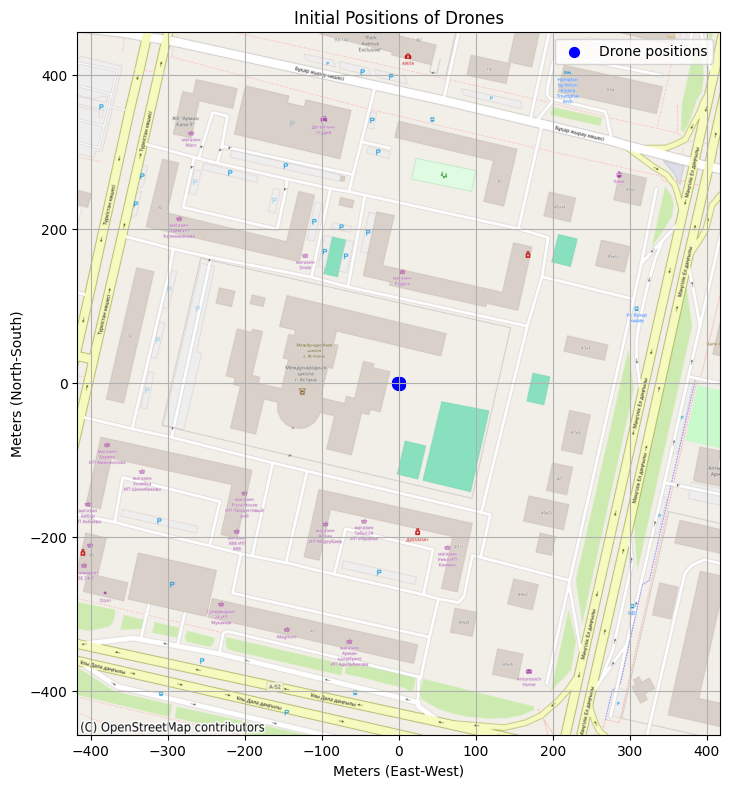

In [39]:

fig, ax = plt.subplots(figsize=(8.35, 9.13))

# Example: Setting background using the function
set_map_background(ax, 'downloaded_map.png', map_width_m=835, map_height_m=913)
plot_drone_positions(ax=ax, positions=positions)
plt.show()

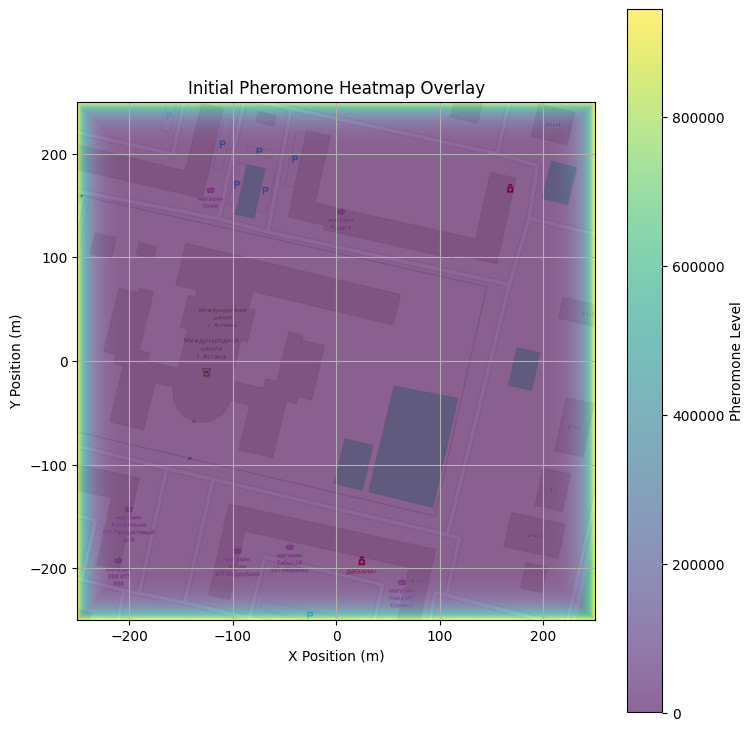

In [40]:
import torch
import matplotlib.pyplot as plt

def plot_pheromone_heatmap(ax, pheromone_matrix):
    """
    Plots the pheromone matrix (excluding out-of-bounds) as a heatmap,
    centered at (0,0), with 1 unit = 1 meter.

    Args:
        ax: Matplotlib axis where the background map is already drawn.
        pheromone_matrix: 2D torch tensor of shape (502, 502).
    """
    # Extract only the in-bound grid: indices [1:501]
    pheromone_np = pheromone_matrix[1:501, 1:501].cpu().numpy()

    # Since grid is 500x500, center ranges from -250 to +250 (half of 500)
    extent = (-250, 250, -250, 250)

    # Plot heatmap
    cax = ax.imshow(
        pheromone_np,
        origin='lower',
        extent=extent,
        cmap='viridis',
        alpha=0.6  # Adjust transparency if needed
    )

    plt.colorbar(cax, ax=ax, label='Pheromone Level')

# Example usage:
fig, ax = plt.subplots(figsize=(8.35, 9.13))  # Or your background function here
# ax = set_map_background(ax, ...)      # Assuming your map is already set as background
set_map_background(ax, 'downloaded_map.png',  map_width_m=835, map_height_m=913)
# Generate your pheromone matrix
device = 'cpu'
MAX_PHEROMONE = torch.exp2(torch.tensor(20, dtype=torch.float64, device=device))
PHEROMONE_MATRIX = torch.zeros((502, 502), dtype=torch.float64, device=device)

def fill_initial_pheromone():
    global PHEROMONE_MATRIX
    indices = torch.arange(502, dtype=torch.float64, device=device)
    i_grid, j_grid = torch.meshgrid(indices, indices, indexing='ij')
    min_dist = torch.stack([i_grid, 501 - i_grid, j_grid, 501 - j_grid], dim=0).amin(dim=0)
    decay_base = 0.9
    PHEROMONE_MATRIX = MAX_PHEROMONE * torch.pow(decay_base, min_dist)

fill_initial_pheromone()

# Plot pheromone matrix as heatmap
plot_pheromone_heatmap(ax, PHEROMONE_MATRIX)

plt.title('Initial Pheromone Heatmap Overlay')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.show()


In [41]:
import psycopg2
import pandas as pd

def plot_drone_trajectories_on_ax(ax, episode_id, db_params=DB_PARAMS):
    """
    Plots drone trajectories on the provided matplotlib axis.

    Args:
        ax (matplotlib.axes.Axes): The axis where the map is already plotted.
        episode_id (int): ID of the episode.
        db_params (dict): Database connection parameters.
    """

    # Connect to the database
    conn = psycopg2.connect(**db_params
    )
    cur = conn.cursor()

    # SQL query
    query = """
        SELECT drone_id, position_x, position_y, timestep
        FROM position_logs
        WHERE episode_id = %s
        ORDER BY drone_id, timestep

    """
    cur.execute(query, (episode_id,))
    rows = cur.fetchall()

    # Convert to DataFrame
    df = pd.DataFrame(rows, columns=['drone_id', 'position_x', 'position_y', 'timestep'])

    # Plot trajectories
    for drone_id, group in df.groupby('drone_id'):
        ax.plot(group['position_x'], group['position_y'], label=f'Drone {drone_id}')
        ax.scatter(group['position_x'].iloc[0], group['position_y'].iloc[0],
                   marker='o', color='green', label=f'Start {drone_id}' if drone_id == group['drone_id'].min() else "")
        ax.scatter(group['position_x'].iloc[-1], group['position_y'].iloc[-1],
                   marker='x', color='red', label=f'End {drone_id}' if drone_id == group['drone_id'].min() else "")

    ax.legend()
    ax.set_xlabel('X Position (m)')
    ax.set_ylabel('Y Position (m)')
    ax.grid(True)

    # Close DB connection
    cur.close()
    conn.close()


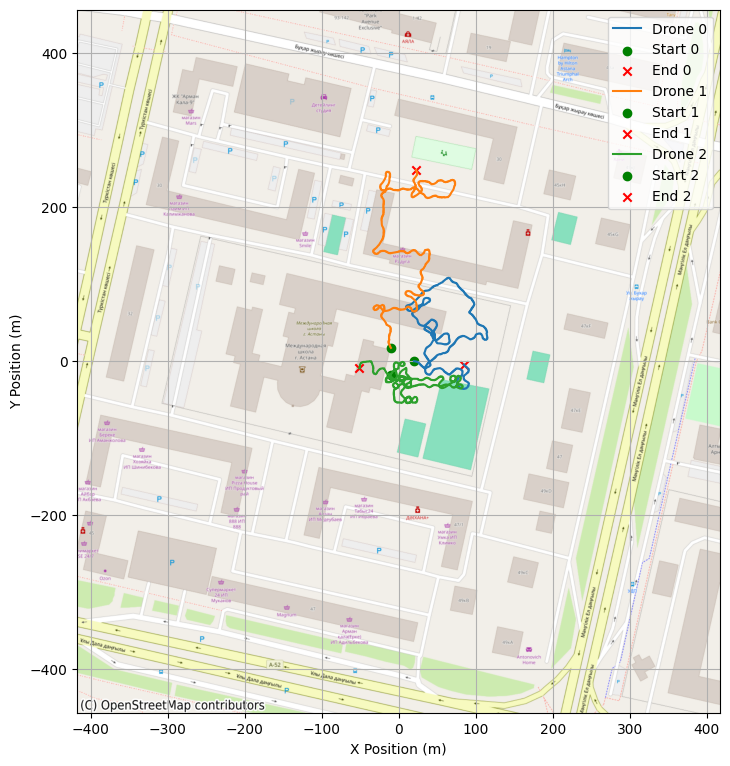

In [52]:

fig, ax = plt.subplots(figsize=(8.35, 9.13))  # Or your background function here
# ax = set_map_background(ax, ...)      # Assuming your map is already set as background
set_map_background(ax, 'downloaded_map.png',  map_width_m=835, map_height_m=913)
 .
plot_drone_trajectories_on_ax(ax, 85)